[*********************100%***********************]  1 of 1 completed


Price            Close        High         Low        Open    Volume
Ticker            AAPL        AAPL        AAPL        AAPL      AAPL
Date                                                                
2023-05-24  170.136536  170.710788  168.829629  169.393970  45143500
2023-05-25  171.275162  172.176129  169.988046  170.700909  56058300
2023-05-26  173.690964  174.027605  171.393970  171.601895  54835000
2023-05-30  175.542435  177.215684  174.819675  175.205809  55964400
2023-05-31  175.492920  177.572109  175.007772  175.572129  99625300


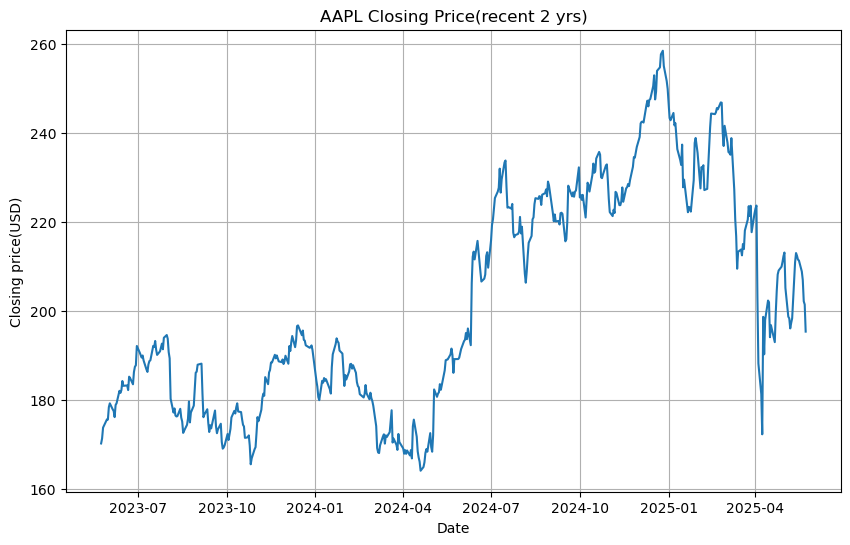

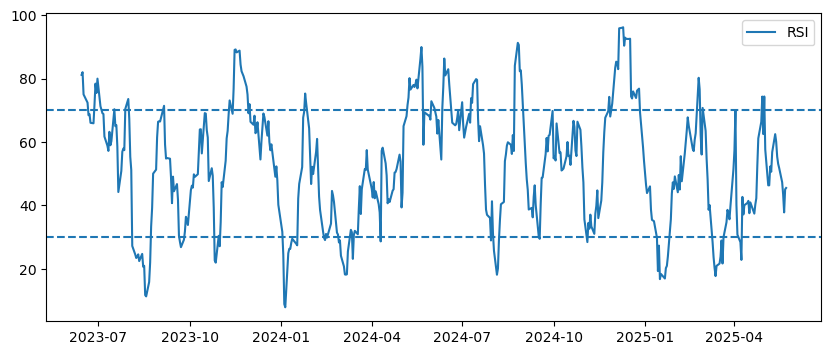

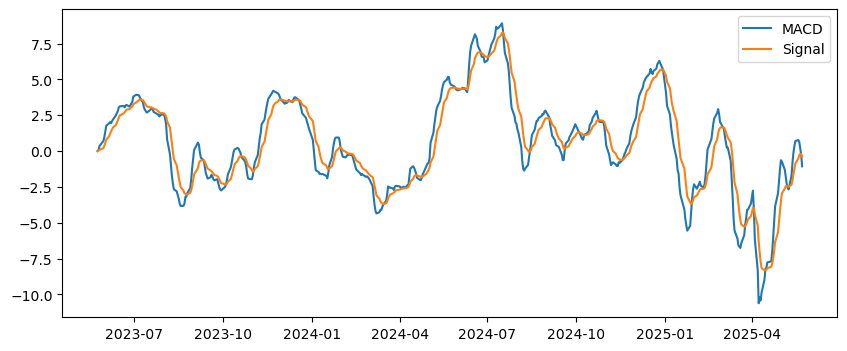

Sharpe ratio: 0.7092207075206246


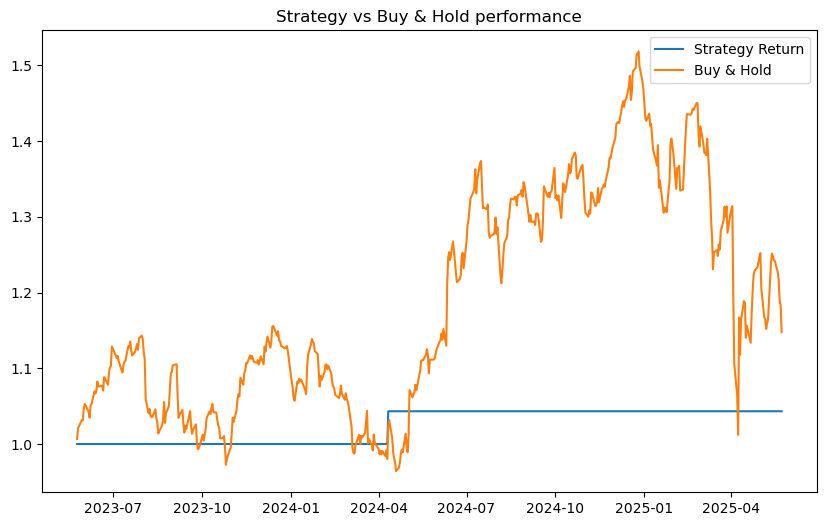

In [47]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt

#Fetch data from Apple
ticker = "AAPL"
data = yf.download(ticker, period="2y", interval="1d")
#Take a look at the data
print(data.head())

#Visualization
plt.figure(figsize=(10,6))
plt.plot(data.index, data["Close"])
plt.title(f"{ticker} Closing Price(recent 2 yrs)")
plt.xlabel("Date")
plt.ylabel("Closing price(USD)")
plt.grid(True)
plt.show()

#Calculate RSI
delta = data['Close'].diff()
gain = delta.clip(lower=0)
loss = -delta.clip(upper=0)
window = 14
avg_gain = gain.rolling(window).mean()
avg_loss = loss.rolling(window).mean()
rs = avg_gain / avg_loss
data['RSI'] = 100 - (100 / (1 + rs))

#Calculate MACD
exp1 = data['Close'].ewm(span=12, adjust=False).mean()
exp2 = data['Close'].ewm(span=26, adjust=False).mean()
data['MACD'] = exp1 - exp2
data['Signal'] = data['MACD'].ewm(span=9, adjust=False).mean()

#Plot RSI
plt.figure(figsize=(10,4))
plt.plot(data.index, data['RSI'], label='RSI')
plt.axhline(70, linestyle='--')
plt.axhline(30, linestyle='--')
plt.legend()
plt.show()

#Plot MACD & Signal
plt.figure(figsize=(10,4))
plt.plot(data.index, data['MACD'], label='MACD')
plt.plot(data.index, data['Signal'], label='Signal')
plt.legend()
plt.show()

#Add Position column in data
data['Position'] = 0
buy_signal = (data['RSI'] < 30) & (data['MACD'] > data['Signal'])
sell_signal = (data['RSI'] > 70) & (data['MACD'] < data['Signal'])
data.loc[buy_signal, 'Position'] = 1
data.loc[sell_signal, 'Position'] = 0
data['Position'] = data['Position'].ffill().fillna(0)

#Calculate performance indicators
data['Return'] = (data['Close'].pct_change()).squeeze() * data['Position'].shift()
cumulative_return = (1 + data['Return']).cumprod()
max_drawdown = (cumulative_return.cummax() - cumulative_return).max()
sharpe_ratio = data['Return'].mean() / data['Return'].std() * (252**0.5)
print("Sharpe ratio:",sharpe_ratio)

#Visualize backtesting results
plt.figure(figsize=(10,6))
plt.plot(cumulative_return, label = 'Strategy Return')
plt.plot((1 + data['Close'].pct_change()).cumprod(), label = 'Buy & Hold')
plt.legend()
plt.title('Strategy vs Buy & Hold performance')
plt.show()